## Import libraries

In [4]:
import os
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import TensorBoard, EarlyStopping
import time

In [14]:
DATASET_PATH  = './data/data_1031'
IMAGE_SIZE    = (299, 299)
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 308  # freeze the first this many layers for training
NUM_EPOCHS    = 50

WEIGHTS_FINAL = 'final-Inception-final.h5'
TOP_LAYERS_CHECKPOINT_PATH = 'top-best_Incpt.hdf5'
FINE_TUNED_CHECKPOINT_PATH = 'finetuned-best_Incpt.hdf5'


## Define the training set and validation set

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 19937 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')


****************
Class #0 = cats
Class #1 = dogs
****************


## Define the model and set the checkpoint

In [8]:
# create the base model
base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
#x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(1024, activation='relu', name='relu')(x)
# add logistic layer
output_layer = Dense(2, activation='softmax', name='softmax')(x)
final_model = Model(input=base_model.input, output=output_layer)

87916544/87910968 [==============================] - 834s 9us/step


D:\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
  if sys.path[0] == '':


In [15]:
if os.path.exists(TOP_LAYERS_CHECKPOINT_PATH):
    final_model.load_weights(TOP_LAYERS_CHECKPOINT_PATH)
    print("Checkpoint '" + TOP_LAYERS_CHECKPOINT_PATH + "' loaded.")

Checkpoint 'top-best_Incpt.hdf5' loaded.


## Train only the top layers we added

In [9]:
for layer in base_model.layers:
    layer.trainable = False

final_model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Save the TensorBoard logs.# Save the model after every epoch.
mc_top = ModelCheckpoint(TOP_LAYERS_CHECKPOINT_PATH, monitor='val_acc',verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

logs = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

stp = EarlyStopping(monitor='val_loss', patience=6, verbose=0, mode='auto')


In [11]:
t0 = time.time()
# train the model
hist_top = final_model.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        callbacks=[mc_top, reduce_lr, stp,logs])

t1 = time.time()
print('time consumed:', (t1-t0))

Epoch 1/50
623/623 [==============================] - 440s 707ms/step - loss: 0.3017 - acc: 0.8702 - val_loss: 0.0791 - val_acc: 0.9702
Epoch 2/50
623/623 [==============================] - 428s 687ms/step - loss: 0.1757 - acc: 0.9317 - val_loss: 0.0514 - val_acc: 0.9823
Epoch 3/50
623/623 [==============================] - 427s 685ms/step - loss: 0.1623 - acc: 0.9365 - val_loss: 0.0640 - val_acc: 0.9779
Epoch 4/50
623/623 [==============================] - 428s 686ms/step - loss: 0.1504 - acc: 0.9426 - val_loss: 0.0514 - val_acc: 0.9833
Epoch 5/50
623/623 [==============================] - 428s 686ms/step - loss: 0.1376 - acc: 0.9472 - val_loss: 0.0539 - val_acc: 0.9825
Epoch 6/50
623/623 [==============================] - 429s 688ms/step - loss: 0.1386 - acc: 0.9486 - val_loss: 0.0567 - val_acc: 0.9813
Epoch 7/50
623/623 [==============================] - 428s 688ms/step - loss: 0.1300 - acc: 0.9513 - val_loss: 0.0584 - val_acc: 0.9811
Epoch 8/50
623/623 [============================

## Visualize the training process

In [12]:
import matplotlib.pyplot as plt
# plot the figures

def visualize(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    
    fig = plt.figure(figsize = (8,4))
    
    # plot loss first
    ax_loss = fig.add_subplot(121)
    ax_loss.plot(loss, label = 'train_loss')
    ax_loss.plot(val_loss, label='validation_loss')
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Loss')
    ax_loss.legend()
    
    # plot the accuracy
    ax_acc = fig.add_subplot(122)
    ax_acc.plot(acc, label = 'train_acc')
    ax_acc.plot(val_acc, label='validation_acc')
    ax_acc.set_xlabel('Epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_title('Accuracy')
    ax_acc.legend()
    
    plt.tight_layout()
    plt.show()



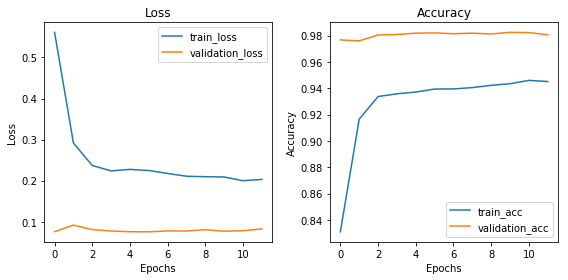

In [35]:
visualize(hist_top)

In [13]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
    


0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

## Release parameters from more layers to train

In [16]:
mc_fit = ModelCheckpoint(FINE_TUNED_CHECKPOINT_PATH, monitor='val_acc',
                          verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#if os.path.exists(FINE_TUNED_CHECKPOINT_PATH):
#    final_model.load_weights(FINE_TUNED_CHECKPOINT_PATH)
#    print ("Checkpoint '" + FINE_TUNED_CHECKPOINT_PATH + "' loaded.")

In [17]:
for layer in final_model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in final_model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
final_model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
print(final_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [18]:
t2=time.time()

# train the model
hist_finetune = final_model.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        callbacks=[mc_fit, reduce_lr, stp,logs])

t3 = time.time()
print('time consumed:', (t3-t2))

Epoch 1/50
623/623 [==============================] - 438s 703ms/step - loss: 0.1439 - acc: 0.9472 - val_loss: 0.0347 - val_acc: 0.9899
Epoch 2/50
623/623 [==============================] - 431s 692ms/step - loss: 0.1369 - acc: 0.9487 - val_loss: 0.0629 - val_acc: 0.9802
Epoch 3/50
623/623 [==============================] - 430s 690ms/step - loss: 0.1237 - acc: 0.9528 - val_loss: 0.0661 - val_acc: 0.9803
Epoch 4/50
623/623 [==============================] - 430s 690ms/step - loss: 0.1194 - acc: 0.9546 - val_loss: 0.0653 - val_acc: 0.9807
Epoch 5/50
623/623 [==============================] - 430s 690ms/step - loss: 0.1225 - acc: 0.9552 - val_loss: 0.0616 - val_acc: 0.9829
Epoch 6/50
623/623 [==============================] - 430s 691ms/step - loss: 0.1171 - acc: 0.9550 - val_loss: 0.0571 - val_acc: 0.9831
Epoch 7/50
623/623 [==============================] - 431s 692ms/step - loss: 0.1162 - acc: 0.9565 - val_loss: 0.0656 - val_acc: 0.9811
time consumed: 3038.370771884918


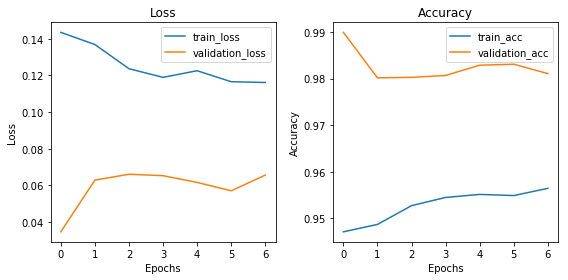

In [19]:
visualize(hist_finetune)
